In [1]:
# Import libraries
import os
from pprint import pprint
import datetime

# Data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("ticks")
sns.set_context("notebook")

#### Madrid AirBnb Data

*In this analysis we are using the data from Airbnb from the city of Madrid. We are going to explore how can we approach some useful business questions from the data we have. Real state data is one of the hottest topics nowadays having into account the progressive increase of the living places prices, overcrowded big metropolitan cities in which living near the center is rather impossible for some people, new ways of tourism, etc. That's way selecting this dataset is so appealing. It's Airbnb data. Airbnb is a highly succesful company that has achieved being a start-up less than 5 years ago and now being an international company that operates all around the world. It basically acts as an intermediary between short-stay dwellings owners and mostly low-cost tourism seekers. It enables people to share their own living place with someone by a lower payment compared to traditional hotels. This business has created a lot of ad-hoc opportunities, as we will try to expose in this analysis.*

#### Table of contents
1. *Overview of the data: explanation of variables, scope, etc*
2. *Propose some business questions or possible insights that we could answer with the data we have*
3. *Arrange the dataset from all the sources available so that it contains the maximum information possible*
4. *Analyze statistically the data, evaluate missing values and present a hypothesis to clean the data*
5. *Analyze possible correlations among features, explore on useful data transformations*
6. *Modelling: Set a target variable that we want to predict based on the business question proposed and experiment different machine learning models*

> ***Data overview***
<br>*Explore tha main statistical variables from the data, define the features we have, explain the datasets available*

In [3]:
# Load the datasets available

data = r"data"
calendar = os.path.join(data, "calendar.csv")
listings = os.path.join(data, "listings.csv")
reviews = os.path.join(data, "reviews.csv")

caldf = pd.read_csv(calendar)
listdf = pd.read_csv(listings)
revdf = pd.read_csv(reviews)

c:\users\manuelmartin\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


> ***Description of each source file***: *(All files have been compiled on 8th of March, 2019)*
- *calendar.csv: Detailed calendar data for listings in Madrid. This file contains the periods of time where*
- *listings.csv: Detailed listings data for Madrid*
- *reviews.csv: Detailed review data for listings in Madrid*


In [4]:
# Overview of available datasets
def show_information_from_dataset(df, name):
    
    print(df.info())  
    missing_values_rate = (caldf.isna().sum()/df.shape[0]).sum()/df.shape[1]
    
    print("=="*40)
    print(f"""
    {name} Dataset Information:
    Number of rows: {df.shape[0]},
    Number of features: {df.shape[1]},
    Missing values rate: {missing_values_rate}
    """)
    print("=="*40)
    
show_information_from_dataset(caldf, "Calendar")
show_information_from_dataset(listdf, "Listings")
show_information_from_dataset(revdf, "Reviews")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444440 entries, 0 to 6444439
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 344.2+ MB
None

    Calendar Dataset Information:
    Number of rows: 6444440,
    Number of features: 7,
    Missing values rate: 0.0
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17656 entries, 0 to 17655
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 14.3+ MB
None

    Listings Dataset Information:
    Number of rows: 17656,
    Number of features: 106,
    Missing values rate: 0.0
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615004 entries, 0 to 615003
Data columns (total 6 columns):
listing_id       615004 non-null int64
id               615004 non-null int64
date             615004 non-

#### Calendar Dataset

 > ***Visualization of sample rows from Calendar Dataframe***:  This dataset contains the dates from all the different listings information in terms of price and availablity. It contains more than one row per listing_id because the prices and availability changes per day. The availability is encoded as "f" and "t" where "f" means False and "t" means True. The adjusted price is also encoded as a string because it contains the dollar symbol. We can see from the date range that it is also considered a very long range of time since march. At a certain point of time, the data won't be much reliable as there are a number of external factors that can affect the prices, availability, and minimum and maximum nights. It also seems that there are no missing values in the dataset.

In [5]:
caldf.head(6)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,6369,2019-03-08,f,$50.00,$50.00,3,30
1,283862,2019-03-08,f,$150.00,$150.00,1,1125
2,283862,2019-03-09,f,$85.00,$85.00,1,1125
3,283862,2019-03-10,f,$70.00,$70.00,1,1125
4,283862,2019-03-11,t,$50.00,$50.00,1,1125
5,283862,2019-03-12,t,$50.00,$50.00,1,1125


In [6]:
print(f"Minimum date considered {caldf.date.min()}")
print(f"Maximum date considered {caldf.date.max()}")

Minimum date considered 2019-03-08
Maximum date considered 2020-03-06


In [7]:
# Find missing values in each feature
caldf.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

> *Minor data type adjustments on features: We will transform "date" as a proper datetime feature, and transform prices into a quantitative field rather than a string. We will also encode "available" feature to be a 0 or 1.*

In [8]:
# Transform date field into date time
caldf["datetime"] = pd.to_datetime(caldf["date"], format="%Y-%m-%d")

# Transform available categories into binary
caldf["available"] = caldf["available"].astype("category").cat.codes

# Transform prices string value into float
caldf["price"] = caldf["price"].apply(lambda x: float(x[1:].replace(",", "")))
caldf["adjusted_price"] = caldf["adjusted_price"].apply(lambda x: float(x[1:].replace(",", "")))

> *Visualize mean price by date: Check if there is some peak season in which prices are very high*

In [9]:
mean_price_by_date = caldf.groupby(["datetime"])["price"].mean()
mean_adjustedprice_by_date = caldf.groupby(["datetime"])["adjusted_price"].mean()

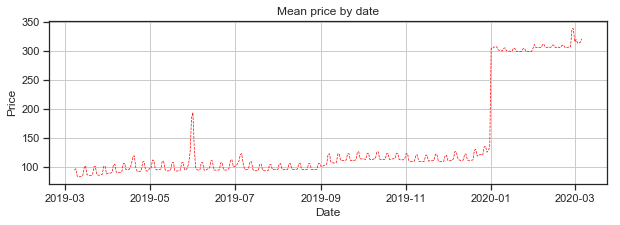

In [10]:
plt.figure(figsize=(10,3))
plt.title("Mean price by date")
plt.grid(True)
plt.plot(mean_price_by_date, c="red", linestyle="--", linewidth=0.7)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

### Listings

 > ***Visualization of sample rows from Listings Dataframe***:

In [11]:
listdf.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20190308052744,2019-03-08,"Rooftop terrace room with ensuite bathroom, Airc.","Atico en la calle Principe de Vergara, con bañ...",BETTER THAN A HOTEL.Upscale neighboorhood (Met...,BETTER THAN A HOTEL.Upscale neighboorhood (Met...,none,Nice and definitely non touristic neighborhoo...,...,f,f,flexible,f,f,1,0,1,0,0.55
1,21853,https://www.airbnb.com/rooms/21853,20190308052744,2019-03-08,Bright and airy room,We have a quiet and sunny room with a good vie...,I am living in a nice flat near the centre of ...,We have a quiet and sunny room with a good vie...,none,We live in a leafy neighbourhood with plenty o...,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.61
2,24805,https://www.airbnb.com/rooms/24805,20190308052744,2019-03-08,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...",LOCATION. Brand new flats near the Atlantic H...,"Studio located 50 meters from Gran Via, next t...",none,"The area is next to the Gran Via, so people li...",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.04


In [12]:
listdf.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17656 entries, 0 to 17655
Data columns (total 106 columns):
id                                              int64
listing_url                                     object
scrape_id                                       int64
last_scraped                                    object
name                                            object
summary                                         object
space                                           object
description                                     object
experiences_offered                             object
neighborhood_overview                           object
notes                                           object
transit                                         object
access                                          object
interaction                                     object
house_rules                                     object
thumbnail_url                                   float64
medium_url 

> *Removal of features not relevant to the case*

In [13]:
url_related_features = ["thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_url", "host_thumbnail_url", "host_picture_url"]
listdf = listdf.drop(url_related_features, axis=1)

#### ***Data Cleaning and transformations***

*At this step, we are going to perform a first cleaning of the listings dataframe, which consists of a large range of features. Some of them are encoded as categories, others need to be encoded as numbers, others need to be refactored, etc*

> *Missing Values Analysis: Analyze the number of missing values in the dataset. Check if the appearance of missing values are from the type MAR or NMAR to validate if the missing values follow a specific pattern or not*

***Type of missing values***
- *Missing values at Random: The observed missing values are randomly distributed across more than 1 sample of the dataset.*
- *Missing Completely at Random: This happens when all missing values are randomly distributed throughout all observations. This can be confirmed by splitting the dataset in 2, one containing all missing values and the other containing the no missing values. We can use then, the t-test to find statistic differences among the dataset samplings*
- *Non ignorable Missing Values: These are the missing values that are not randomly distributed and follow a certain pattern*

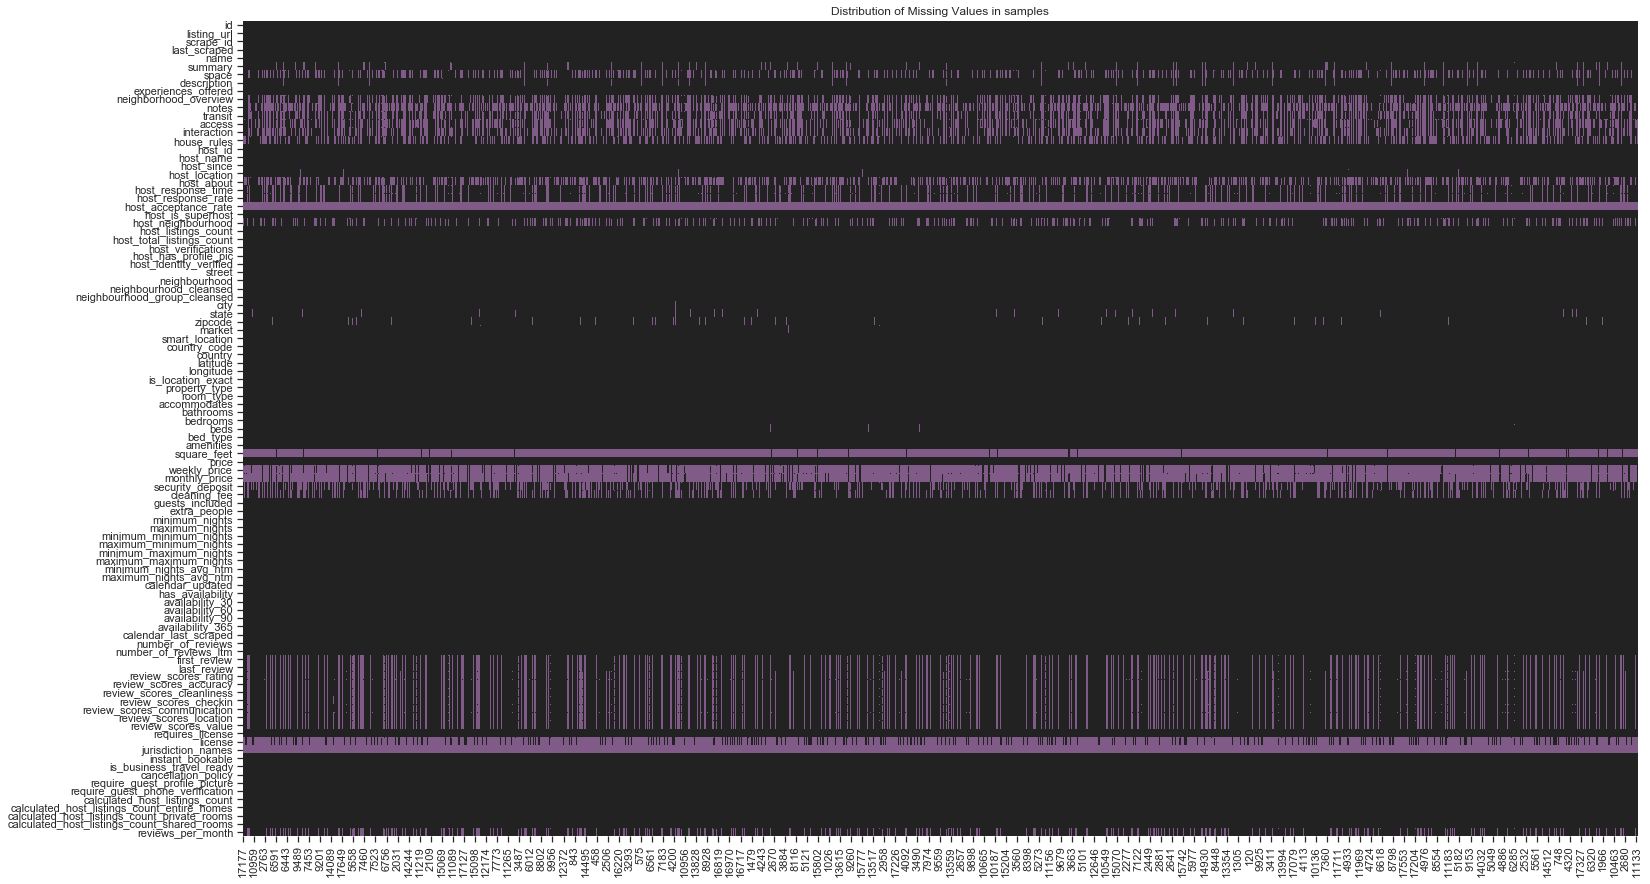

In [14]:
plt.figure(figsize=[25,15])
plt.title("Distribution of Missing Values in samples")
sns.heatmap(listdf.sample(frac=1).isna().T, cbar=False, yticklabels=True, square=False, cmap=sns.dark_palette("muted purple", input="xkcd"))
plt.show()

> *At first glance, there seems to be no relationship among the appeareances of missing values from the sample above and the feature where they belong. The existence of missing values is closely related with the optional and mandatory data or information that must be provided when posting a listing in Airbnb. We can conclude that the missing values presented in this dataset are of the type MAR, so there is no need to convey a further analysis on missing values pattern recognition. After this assesment, we are going to remove the features that have a very high rate of missing values as they won't give us enought representativity within the upcoming analysis and business cases to be proposed*

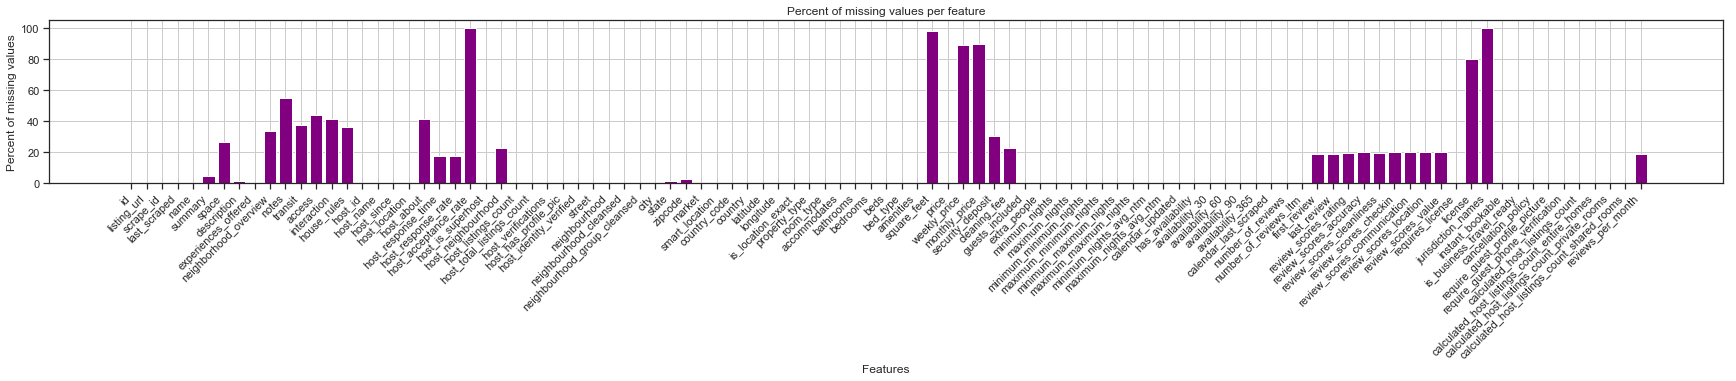

In [15]:
# Plot the amount of missing values per feature

plt.figure(figsize=(30, 3))
plt.title("Percent of missing values per feature")
plt.bar(listdf.isna().sum().index, (listdf.isna().sum().values/listdf.shape[0])*100, color="purple")
plt.grid(True)
plt.xlabel("Features")
plt.ylabel("Percent of missing values")
plt.xticks(rotation=45, ha="right")
plt.show()

In [16]:
# Delete the rows with a very high number of missing values (>25%)
threshold = 0.25
columns_to_drop = listdf.columns[listdf.isna().sum()/listdf.shape[0] > threshold].tolist()
print("Columns to be dropped...")
for col in columns_to_drop:
    print(f"- {col}")
     
listdf = listdf.drop(labels=columns_to_drop, axis=1)

Columns to be dropped...
- space
- neighborhood_overview
- notes
- transit
- access
- interaction
- house_rules
- host_about
- host_acceptance_rate
- square_feet
- weekly_price
- monthly_price
- security_deposit
- license
- jurisdiction_names


> *Analyze string-data-type features: Visualize some examples of each of the string columns present in the dataset*

In [17]:
string_columns = listdf.select_dtypes(include="O").columns.tolist()

In [18]:
# Analyze amount of missing values per row
np.round((listdf.select_dtypes(include="O").isna().sum()/listdf.shape[0])*100, 2)

listing_url                          0.00
last_scraped                         0.00
name                                 0.03
summary                              4.59
description                          1.80
experiences_offered                  0.00
host_name                            0.02
host_since                           0.02
host_location                        0.24
host_response_time                  17.47
host_response_rate                  17.47
host_is_superhost                    0.02
host_neighbourhood                  22.58
host_verifications                   0.00
host_has_profile_pic                 0.02
host_identity_verified               0.02
street                               0.00
neighbourhood                        0.01
neighbourhood_cleansed               0.00
neighbourhood_group_cleansed         0.00
city                                 0.02
state                                1.60
zipcode                              2.75
market                            

In [19]:
# Drop all null rows from the string features exposed above
indices_to_maintain = listdf[string_columns].dropna().index
listdf = listdf[listdf.index.isin(listdf.index[indices_to_maintain])]

In [21]:
# Show an example of each row
string_columns = listdf.select_dtypes(include="O").columns.tolist()
for col in string_columns:
    print(f"\n{col}")
    #print(f"{col} - {listdf[col][2]}")
    print(f"{listdf[col].describe()}")


listing_url
count                                      8216
unique                                     8216
top       https://www.airbnb.com/rooms/30592997
freq                                          1
Name: listing_url, dtype: object

last_scraped
count           8216
unique             1
top       2019-03-08
freq            8216
Name: last_scraped, dtype: object

name
count                                                 8216
unique                                                8113
top       Fantastic residence ``FUNWAY´´ north zone Madrid
freq                                                     7
Name: name, dtype: object

summary
count                                                  8216
unique                                                 7633
top       - You will enjoy a beautiful room with private...
freq                                                     17
Name: summary, dtype: object

description
count                                                  8216
unique     

> *Decisions to make:* 
- *Remove features who owns low variance, that is, less than 2 unique values*
- *Binary encode features that have 2 categories ("t" and "f")*

In [22]:
to_remove = []
to_encode = []
for col in listdf.select_dtypes(include="O").columns.tolist():
    unique = listdf[col].unique()
    if len(unique) < 2:
        to_remove.append(col)
    elif len(unique) == 2:
        to_encode.append(col)

In [23]:
for col in to_encode:
    listdf[col] = listdf[col].astype("category").cat.codes

print(f"Columns Removed: {to_remove}")
print(f"Columns Encoded: {to_encode}")

Columns Removed: ['last_scraped', 'experiences_offered', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'is_business_travel_ready']
Columns Encoded: ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']


In [24]:
try:
    listdf = listdf.drop(["calendar_updated"], axis=1)
    listdf = listdf.drop(to_remove, axis=1)
    listdf = listdf.drop(["listing_url"], axis=1)
    listdf = listdf.drop(["name"], axis=1)
except:
    pass

> *Analyze remaining features in the dataset from the strings data type: There are a bunch of features in the dataset tha can serve as a great help to discover hidden patterns within the data*

In [25]:
listdf.price = listdf.price.apply(lambda x: float(x[1:].replace(",","")))
lists_to_draw = listdf[listdf.price <= float(listdf.price.quantile(0.95))]

*Data Transformations for geographical data*

In [26]:
neighs = listdf.neighbourhood_group_cleansed.unique()
annotated_centers = []

for neigh in neighs:
    lats_mean = listdf[listdf.neighbourhood_group_cleansed == neigh].latitude.mean()
    longs_mean = listdf[listdf.neighbourhood_group_cleansed == neigh].longitude.mean()
    annotated_centers.append((neigh, longs_mean, lats_mean))

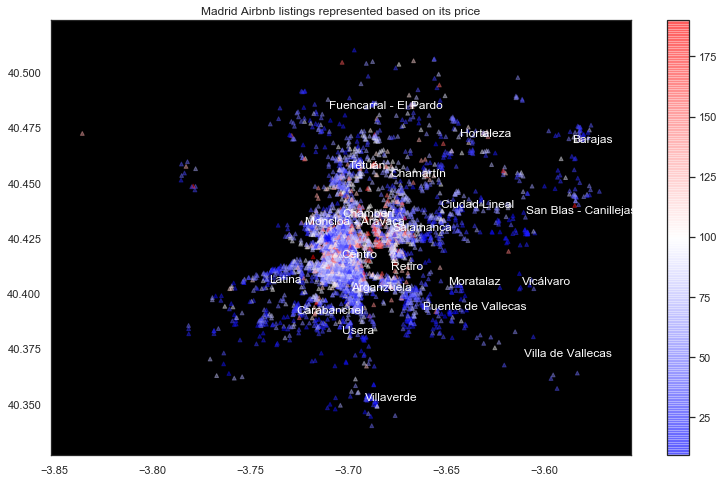

In [27]:
sns.set_style("white")
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)
ax.set_facecolor('xkcd:black')
plt.title("Madrid Airbnb listings represented based on its price")
plt.scatter(lists_to_draw.longitude, 
            lists_to_draw.latitude, 
            s=15, marker="^", alpha=0.4, 
            c=lists_to_draw.price,
            cmap="bwr")
#plt.xlim(-3.77, -3.61)
#plt.ylim(40.37, 40.45)

for pair in annotated_centers:
    ax.annotate(pair[0], xy=(pair[1], pair[2]), color="white")

plt.colorbar()
plt.show()

>*As we can see in the plot above there is not a clear evidence of locations where a specific price concentrates. Nevertheless there is a notable tendency, that the listings outside the city center tend to be red. This is because outside of Madrid city center there is less tourism related places so that the price offer should be lower as less people prefer to stay far from those areas. Also, in the upper right corner and center we can see that there are listings with higher prices, which is one of the upper-class neighbourhoods in Madrid, where there are old palaces, big mansiones, skyscrappers, financial areas, etc. They are called "Chamartín" and "Salamanca".*

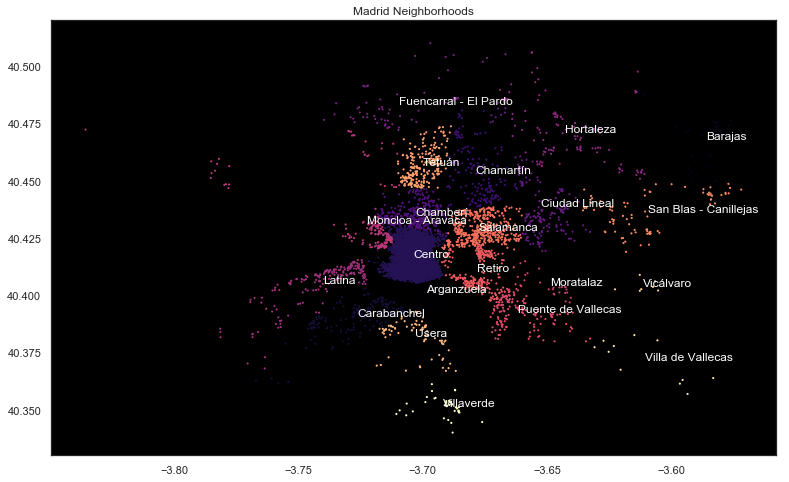

In [28]:
sns.set_style("white")
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)
ax.set_facecolor('xkcd:black')
plt.title("Madrid Neighborhoods")
plt.scatter(lists_to_draw.longitude, 
            lists_to_draw.latitude, 
            s=5, marker=".", 
            c=lists_to_draw.neighbourhood_group_cleansed.astype("category").cat.codes,
            cmap="magma")
#plt.xlim(-3.77, -3.61)
#plt.ylim(40.37, 40.45)

for pair in annotated_centers:
    ax.annotate(pair[0], xy=(pair[1], pair[2]), color="white")

plt.show()

> *In this plot we can clearly see which are the different neighbourhoods in Madrid*

### Which are the neighbourhoods with higher density of Airbnb listings?

The common sense tell us that the center of Madrid will be the most dense zone of the city where Airbnb is present. But let's confirm it. The way to do it is just by counting the listings that belong to each neighbourhood.

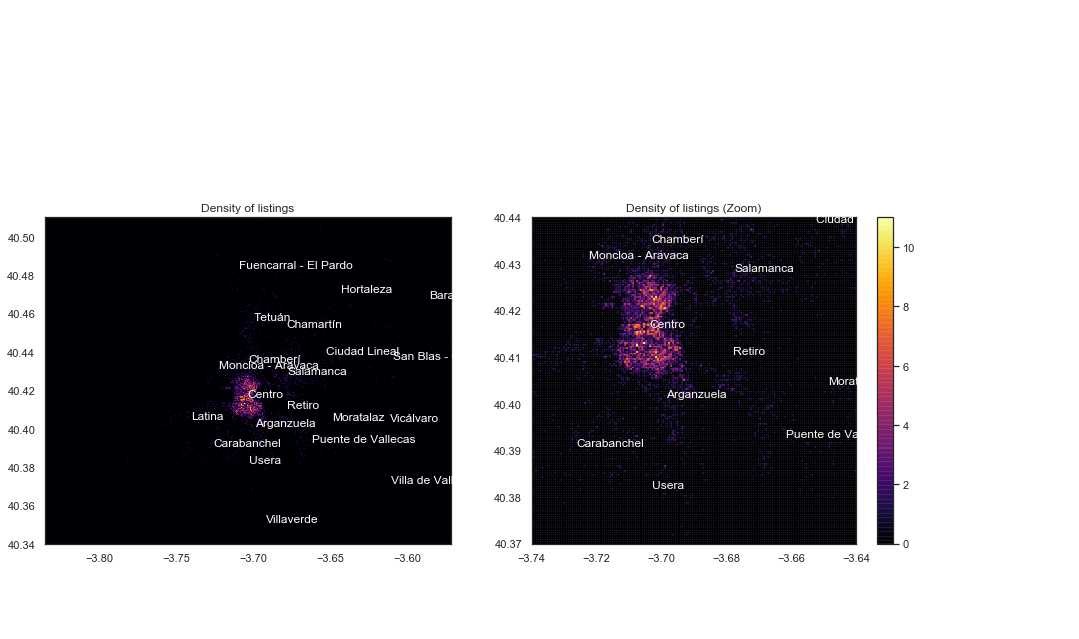

In [29]:
#sns.set_style("white")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
plt.title("Density of listings")
plt.hist2d(lists_to_draw.longitude, 
            lists_to_draw.latitude, bins=450, normed=False, cmap="inferno", alpha=0.9)
#plt.xlim(-3.77, -3.61)
#plt.ylim(40.37, 40.45)

for pair in annotated_centers:
    ax.annotate(pair[0], xy=(pair[1], pair[2]), color="white")

ax = fig.add_subplot(122)
plt.title("Density of listings (Zoom)")
plt.hist2d(lists_to_draw.longitude, 
            lists_to_draw.latitude, bins=450, normed=False, cmap="inferno", alpha=0.9)
plt.xlim(-3.74, -3.64)
plt.ylim(40.37, 40.44)

for pair in annotated_centers:
    ax.annotate(pair[0], xy=(pair[1], pair[2]), color="white")
plt.colorbar()
plt.show()

*Conclusion* We can confirm that our hypothesis is correct, the neigbourhood "Centro" is the most dense zone in the city in terms of Airbnb listings.

#### In which neighbourhood is it more expensive to stay?

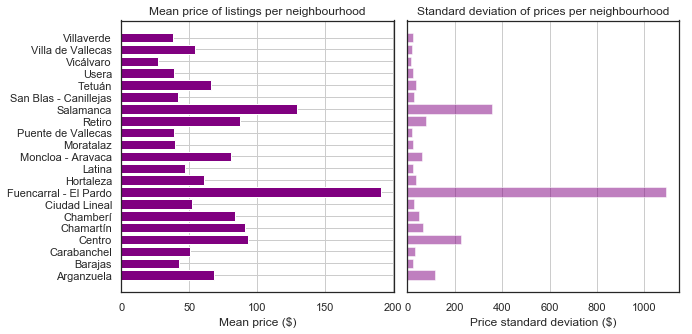

In [30]:
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05)
ax = fig.add_subplot(121)
plt.title("Mean price of listings per neighbourhood")
plt.barh(listdf[["neighbourhood_group_cleansed", "price"]].groupby(by="neighbourhood_group_cleansed").mean().index,
        listdf[["neighbourhood_group_cleansed", "price"]].groupby(by="neighbourhood_group_cleansed").mean().values.flatten(),
        color="purple")
plt.grid(True)
plt.xlabel("Mean price ($)")

ax2 = fig.add_subplot(122)
plt.title("Standard deviation of prices per neighbourhood")
plt.barh(listdf[["neighbourhood_group_cleansed", "price"]].groupby(by="neighbourhood_group_cleansed").std().index,
        listdf[["neighbourhood_group_cleansed", "price"]].groupby(by="neighbourhood_group_cleansed").std().values.flatten(),
        color="purple", alpha=0.5)
plt.yticks([])
plt.xlabel("Price standard deviation ($)")
plt.grid(True)
plt.show()

>*We can visualize in the barplots above that there is a lot of variablity in the neighbourhoods. Nevertheless, there are clear winners in terms of price. For example, "Tetúan", "Salamanca" and "Fuencarral - El Pardo" are the neighbourhoods with the highest mean price. However, it seems that in "Fuencarral - El Pardo" there is also a lot of deviation, which may be indicative of existing very luxury listings there.*

### What can we say about the number of bedrooms of the listing and its relation with the potential guests?

*We can assume that the number of bedrooms is a good indicative of the size of the place.*

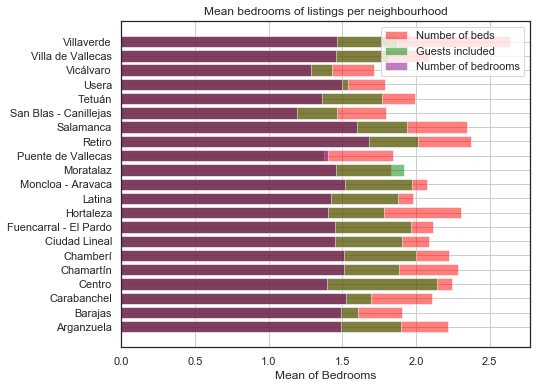

In [31]:
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0.05)
ax = fig.add_subplot(121)
plt.title("Mean bedrooms of listings per neighbourhood")
plt.barh(listdf[["neighbourhood_group_cleansed", "beds"]].groupby(by="neighbourhood_group_cleansed").mean().index,
        listdf[["neighbourhood_group_cleansed", "beds"]].groupby(by="neighbourhood_group_cleansed").mean().values.flatten(),
        color="red", alpha=0.5)
plt.barh(listdf[["neighbourhood_group_cleansed", "guests_included"]].groupby(by="neighbourhood_group_cleansed").mean().index,
        listdf[["neighbourhood_group_cleansed", "guests_included"]].groupby(by="neighbourhood_group_cleansed").mean().values.flatten(),
        color="green", alpha=0.5)
plt.barh(listdf[["neighbourhood_group_cleansed", "bedrooms"]].groupby(by="neighbourhood_group_cleansed").mean().index,
        listdf[["neighbourhood_group_cleansed", "bedrooms"]].groupby(by="neighbourhood_group_cleansed").mean().values.flatten(),
        color="purple", alpha=0.5)


plt.grid(True)
plt.xlabel("Mean of Bedrooms")
plt.legend(["Number of beds", "Guests included", "Number of bedrooms"])
plt.show()

>*We can see in this plot, where we graph the mean number of bedrooms, guests included and the mean number of beds available in the listing, that there are some clear evidences and some others that may lead to interesting discoveries. For example, in "Salamanca" and "Retiro" is clear that the listings have more than 1 bedroom, frequently. But there are some other neighbourhoods as "Centro" or "Chamartín" which frequently have only one room, but in the other hand, it is very frequent to have more than 2 beds. This may say that there are a lot of  listings with only one bedroom, but at the same time, they have 2 beds in the listing (which could be, 2 beds in the same bedroom or 1 bed in the living room). This is interesting from the point of view of which type of guests may rent these listings, there is a clear indicative that these type of people don't mind to share the same bedroom or to sleep in the living room.*

### Are there any hosts who are making business in airbnb?

In [32]:
morethan10_hosts = (listdf.host_id.value_counts()[ listdf.host_id.value_counts() > 30])
hostsdf = listdf[listdf.host_id.isin(morethan10_hosts.index)]
hostsdf.shape

(646, 73)

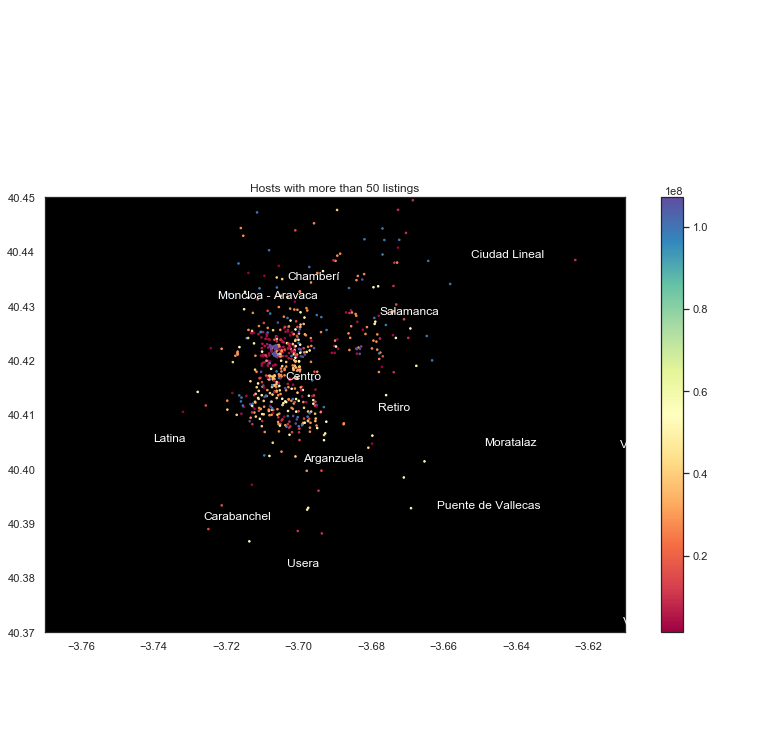

In [33]:
sns.set_style("white")
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)

ax.set_facecolor('xkcd:black')
plt.title("Hosts with more than 50 listings")
plt.scatter(hostsdf.longitude, 
            hostsdf.latitude, 
            s=10, marker=".", 
            c=hostsdf.host_id,
            cmap="Spectral")
plt.xlim(-3.77, -3.61)
plt.ylim(40.37, 40.45)


for pair in annotated_centers:
    ax.annotate(pair[0], xy=(pair[1], pair[2]), color="white")
    
plt.colorbar()
plt.show()                     

In [34]:

print(hostsdf[["host_id", "host_name", "neighbourhood_group_cleansed", "price", "id"]].groupby(["host_name", "neighbourhood_group_cleansed"], axis=0).agg({'id':'count', 'price':'mean'}).rename(columns={'id':'count of listings','price':'mean price'}).to_string())

                                                      count of listings  mean price
host_name               neighbourhood_group_cleansed                               
Apartamentos            Arganzuela                                    1   97.000000
                        Centro                                       36   72.250000
                        Chamartín                                     5   72.800000
                        Chamberí                                      7   59.285714
                        Ciudad Lineal                                 1   55.000000
                        Hortaleza                                     1   45.000000
                        Moncloa - Aravaca                             3   91.333333
                        Retiro                                        1   73.000000
                        Salamanca                                     6   66.833333
Be Mate                 Arganzuela                                    3  130

In [35]:
print(hostsdf[["host_name", "neighbourhood_group_cleansed", "price", "id"]].groupby(["neighbourhood_group_cleansed", "host_name"], axis=0).agg({'id':'count', 'price':'mean'}).rename(columns={'id':'count of listings','price':'mean price'}).to_string())

                                                      count of listings  mean price
neighbourhood_group_cleansed host_name                                             
Arganzuela                   Apartamentos                             1   97.000000
                             Be Mate                                  3  130.000000
                             Eduardo Y Raul                           4   77.500000
                             Emilio                                   1   55.000000
                             Leticia Y Fer                            2   90.500000
                             MHR Madrid Holiday Rent                  2  537.000000
                             My Mad Madrid                            2   65.000000
                             Álvaro & Tatiana                         2   47.000000
Carabanchel                  MHR Madrid Holiday Rent                  2  115.000000
                             Mad4Rent                                 1   75

In [36]:
aggrhosts = hostsdf[["host_name", "neighbourhood_group_cleansed", "price", "id"]].groupby(["neighbourhood_group_cleansed", "host_name"], axis=0, as_index=True).agg({'id':'count', 'price':'mean'}).rename(columns={'id':'count of listings','price':'mean price'})
aggrhosts.index.codes
neighs = aggrhosts.index.levels[0].tolist()
neighs_dict = {num : neigh for num, neigh in enumerate(neighs)}
hosts =  aggrhosts.index.levels[1].tolist()
hosts_dict = {num : neigh for num, neigh in enumerate(hosts)}

neighs_codes = aggrhosts.index.codes[0].tolist()
hosts_codes = aggrhosts.index.codes[1].tolist()

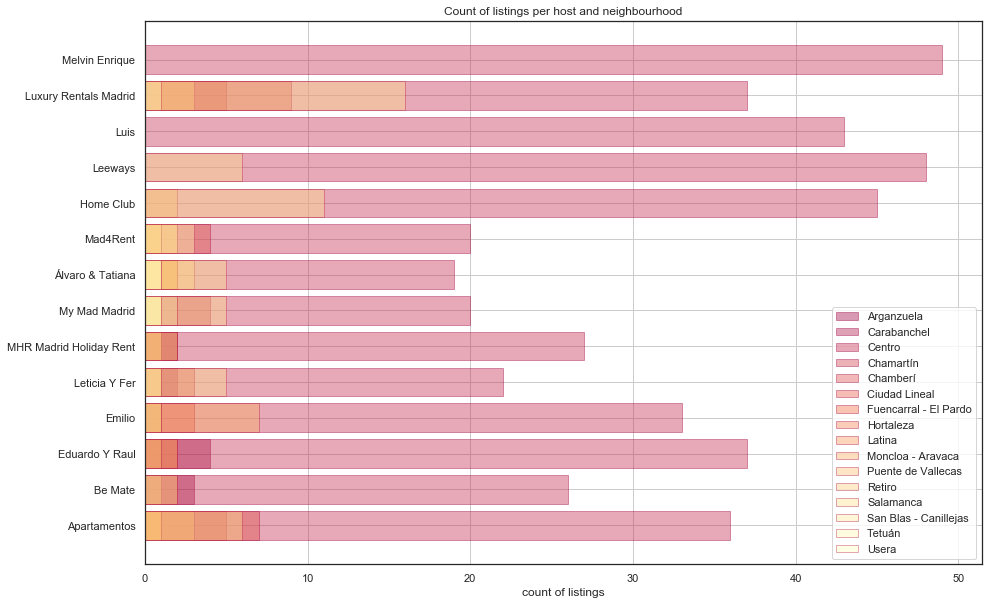

In [37]:
import matplotlib.cm as cm
from matplotlib.patches import Patch
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0,vmax=30)

plt.figure(figsize=(15, 10))
bl = plt.barh([hosts_dict[i] for i in aggrhosts.index.codes[1]], 
               aggrhosts.values[:, 0])

lb_obj = []

for c in np.unique(aggrhosts.index.codes[0]):
    lb_obj.append(Patch(facecolor=cm.Spectral(norm(int(c))), alpha=0.4, edgecolor=cm.Spectral(int(c)),
                         label=neighs_dict[int(c)]))
    
for bin, c in zip(bl, aggrhosts.index.codes[0].astype(np.float).tolist()):
    bin.set_color(cm.Spectral(norm(int(c))))
    bin.set_alpha(0.4)
    bin.set_edgecolor(cm.Spectral(int(c)))
    
plt.legend(handles=lb_obj)
plt.xlabel("count of listings")
plt.title("Count of listings per host and neighbourhood")
plt.grid(True)

plt.show()

> *In the bar plot above we can see that there's a top count of hosts with more than 20 listings owned by them. Some of them seem to be proper companies but some others have person names, so that we can assume that there is a mix of real-state agencies and private investors. This graph may bring several trascendent questions for both Airbnb and the real-state environment.*
- *Is Airbnb losing the essence of its nature, which is basically based on the fresh collaboration economy and turning into an oligopoly of private owners who own a vast amount of living places to make business?*
- *Is this concentration of private owners increasing the prices of living places (for long-lasting stays rental or for sale) in the city center ("Centro")? Which is the area with higher density of airbnb listings as we have been seeing throughout the discovery process.*
- *Having exposed the questions above, should Airbnb limit the number of places listed in its platform per verified user?*

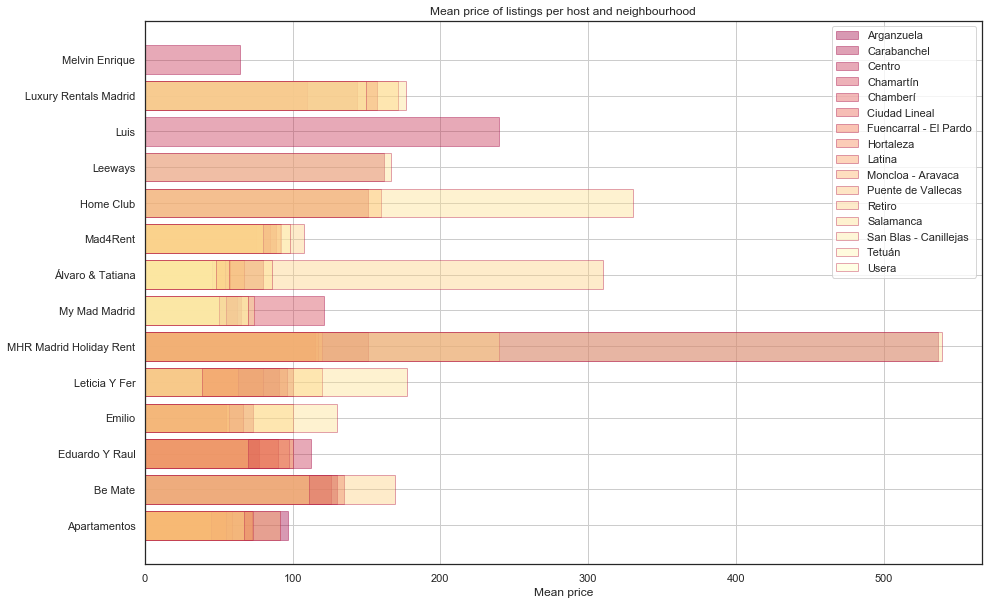

In [38]:
import matplotlib.cm as cm
from matplotlib.patches import Patch
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0,vmax=30)

plt.figure(figsize=(15, 10))
bl = plt.barh([hosts_dict[i] for i in aggrhosts.index.codes[1]], 
               aggrhosts.values[:, 1])

lb_obj = []

for c in np.unique(aggrhosts.index.codes[0]):
    lb_obj.append(Patch(facecolor=cm.Spectral(norm(int(c))), alpha=0.4, edgecolor=cm.Spectral(int(c)),
                         label=neighs_dict[int(c)]))
    
for bin, c in zip(bl, aggrhosts.index.codes[0].astype(np.float).tolist()):
    bin.set_color(cm.Spectral(norm(int(c))))
    bin.set_alpha(0.4)
    bin.set_edgecolor(cm.Spectral(int(c)))
    
plt.legend(handles=lb_obj)
plt.xlabel("Mean price")
plt.title("Mean price of listings per host and neighbourhood")
plt.grid(True)
plt.show()

#### *Evolution of prices over time for next months*

c:\users\manuelmartin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


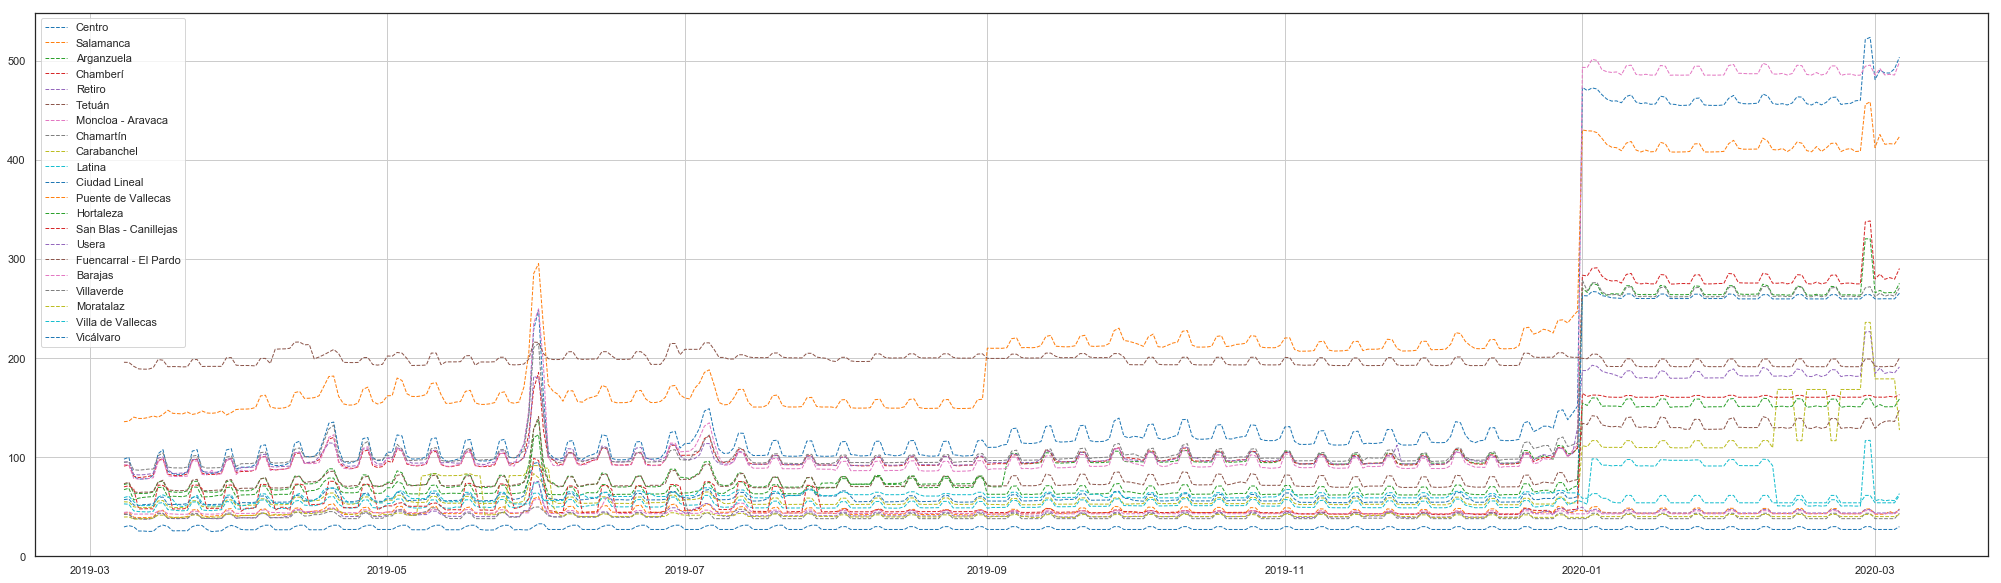

In [39]:
plt.figure(figsize=(35, 10))
to_legend = []
for neigh in list(listdf.neighbourhood_group_cleansed.value_counts().index):
    to_legend.append(neigh)
    ids = listdf[listdf.neighbourhood_group_cleansed == neigh].id
    
    prices_per_neigh = caldf[caldf.listing_id.isin(ids)]
    prices_per_neigh.date = pd.to_datetime(prices_per_neigh["date"], format="%Y-%m-%d")
    mean_prices_per_neigh_per_day = prices_per_neigh[["price", "date"]].groupby(by="date").mean()
    plt.plot(mean_prices_per_neigh_per_day.index, mean_prices_per_neigh_per_day.price, linestyle="--", linewidth=1)

plt.grid(True)
plt.legend(to_legend)
plt.show()


>*In this plot we can see some interesting owner behaviours. There's a clear gap among some of the neighbourhoods in terms of mean price. "Salamanca" has the highest mean price across the upcoming months excepto  when price estimations reach 2020, where "Centro" wins. An intuition that can be obtained from this plot is that owners establish a very high price to their dwellings when the availability is very far in time. This is a kind of safety method or "insurance" for unpredictable far future. That is, owners prefer to put a highly expensive price rather than allowing potential hosts to save the dates for those periods having the usual current mean price. It is a way of securing the cost of opportunity, who knows if in January, the market goes up a lot and we've already booked our flat to a host 6 months ago when the prices were very low. From that perspective, we would be losing money.*